In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
from custom_classes_defs.hed import *

RND_STATE = 247
BATCH_SIZE = 64
FREEZE = 2
EPOCHS = 200
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-06-10 21:50:42.646775: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 21:50:43.465465: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 21:50:43.465931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 21:50:43.590762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 21:50:43.840007: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1
/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Mon Jun 10 21:51:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:3B:00.0 Off |                    0 |
| N/A   32C    P0              34W / 250W |   1637MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Data preparation and model configurations

In [6]:
pets = Oxford_Pets(
        input_dir = "./data/images/",
        target_dir = "./data/annotations/trimaps/",
        img_size = (160, 160),
        pos_label=0,
        batch_size = BATCH_SIZE
    )

train_dataset, valid_dataset, test_dataset = \
        pets.split_data(train_ratio=0.5, val_ratio=0.2, seed=RND_STATE, cache=NUM_GPU, weighted_loss=True)

print(f"training data (size = {pets.train_size})")
print(f"validation data (size = {pets.validation_size})")
print(f"test data (size = {pets.test_size})")
print("Data images tensor:",train_dataset.element_spec[0])
print("Data labels tensor:",train_dataset.element_spec[1])
print("Data weights tensor:",train_dataset.element_spec[-1])


Number of samples: 7390


2024-06-10 21:51:28.731066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36745 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:3b:00.0, compute capability: 8.0


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: premature end of data segment


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Data prep. duration: ___0.33___ minutes.
training data (size = 3695)
validation data (size = 1478)
test data (size = 2217)
Data images tensor: TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None)
Data labels tensor: TensorSpec(shape=(None, 160, 160, 1), dtype=tf.uint8, name=None)
Data weights tensor: TensorSpec(shape=(None, 160, 160, 1), dtype=tf.float32, name=None)


In [7]:

# Model configurations
conf = model_config(
    loss="sparse_categorical_crossentropy",
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    save_path=f'./oxford-pets2/hed{FREEZE}',
    img_shape=pets.img_size,
    target_size=pets.img_size,
    channels_dim=(3,3),
    threshold=pets.threshold,
    pos_label=pets.pos_label,
    new_training_session=True,
    multiple_gpu_device=(NUM_GPU>1),
    train_size=pets.train_size,
    test_size=pets.test_size,
    validation_size=pets.validation_size
)

out_no = 5
hed_out = f'output{out_no}_'
callbacks = conf.callbacks(
    es_monitor=hed_out+'accuracy',
    lr_monitor='val_'+hed_out+'accuracy',
    chkpt_monitor='val_'+hed_out+'loss',
    es_patience=EPOCHS//4
)

conf.set( validation_data=valid_dataset,  callbacks=callbacks )
m1 = f1_score(positive_label=pets.pos_label, threshold=pets.threshold)
weighted_dict = dict([(f'output{k}','sparse_categorical_crossentropy') for k in range(5)])
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.legacy.Adam(1e-4), 
    metrics= ['accuracy', m1],
    weighted_metrics=weighted_dict
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

             NUM_GPU: 1
        compile_args:
                     optimizer: <class 'keras.src.optimizers.legacy.adam.Adam'>
                          loss: sparse_categorical_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
              weighted_metrics: <class 'tensorflow.python.trackable.data_structures._DictWrapper'>
              labels: ListWrapper([0, 1, 2])
     mixed_precision: None
          model_arch:
                     img_shape: (160, 160)
                   target_size: (160, 160)
                  channels_dim: (3, 3)
                       scaling: 255.0
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 0
resume_training_session: 0
           save_path: ./oxford-pets2/hed2
           test_size: 2217
           threshold: 0.5
          train_size: 3695
       training_args:
                        epochs: 200
                   

### Build  model 

In [8]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = HED2D(model_arch=conf.model_arch, num_freeze=FREEZE)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = HED2D(model_arch=conf.model_arch, num_freeze=FREEZE)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Resizing the output to fit input...


Total number of parameters: 14,716,357
Total trainable wieghts: 14,456,197
Total non-trainable wieghts: 260,160


### Train  model

Model training...


2024-06-10 21:52:09.347262: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907



Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.



Epoch 22: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.



Epoch 32: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.



Epoch 42: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.



Epoch 52: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.



Epoch 62: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.



Epoch 72: ReduceLROnPlateau reducing learning rate to 1e-06.


training elapsed time: ___1.57 ___ minutes
...training completed!


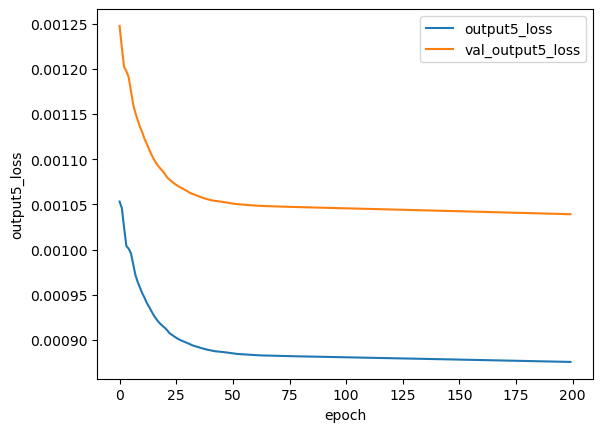

Best model weights loaded!


In [9]:
# print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION,
        metrics=[hed_out+'loss', 'val_'+hed_out+'loss'],
        save_model_history=False
)



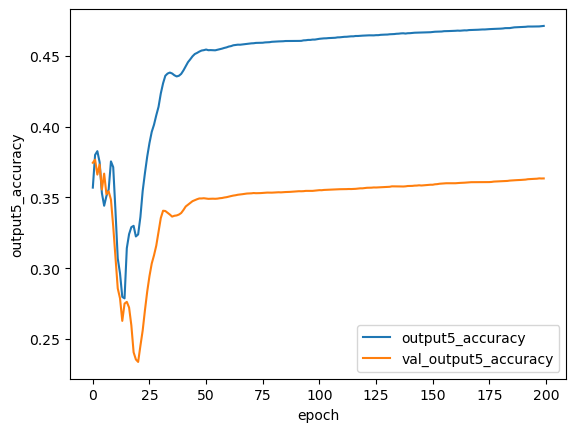

In [10]:
show_convergence(train_history.history, [hed_out+'accuracy','val_'+hed_out+'accuracy'])

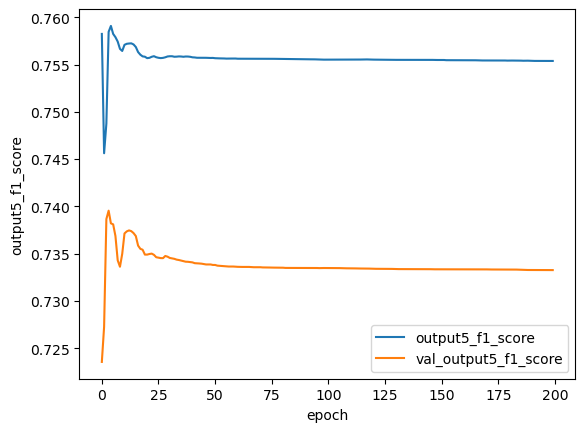

In [11]:
show_convergence(train_history.history, [hed_out+'f1_score','val_'+hed_out+'f1_score'])

### Evaluate and Vizualize

In [12]:
# print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
y_preds = model.predict(test_dataset, verbose=2)


1/1 - 0s - 320ms/epoch - 320ms/step


output 0


output 1
output 2


output 3
output 4


output 5


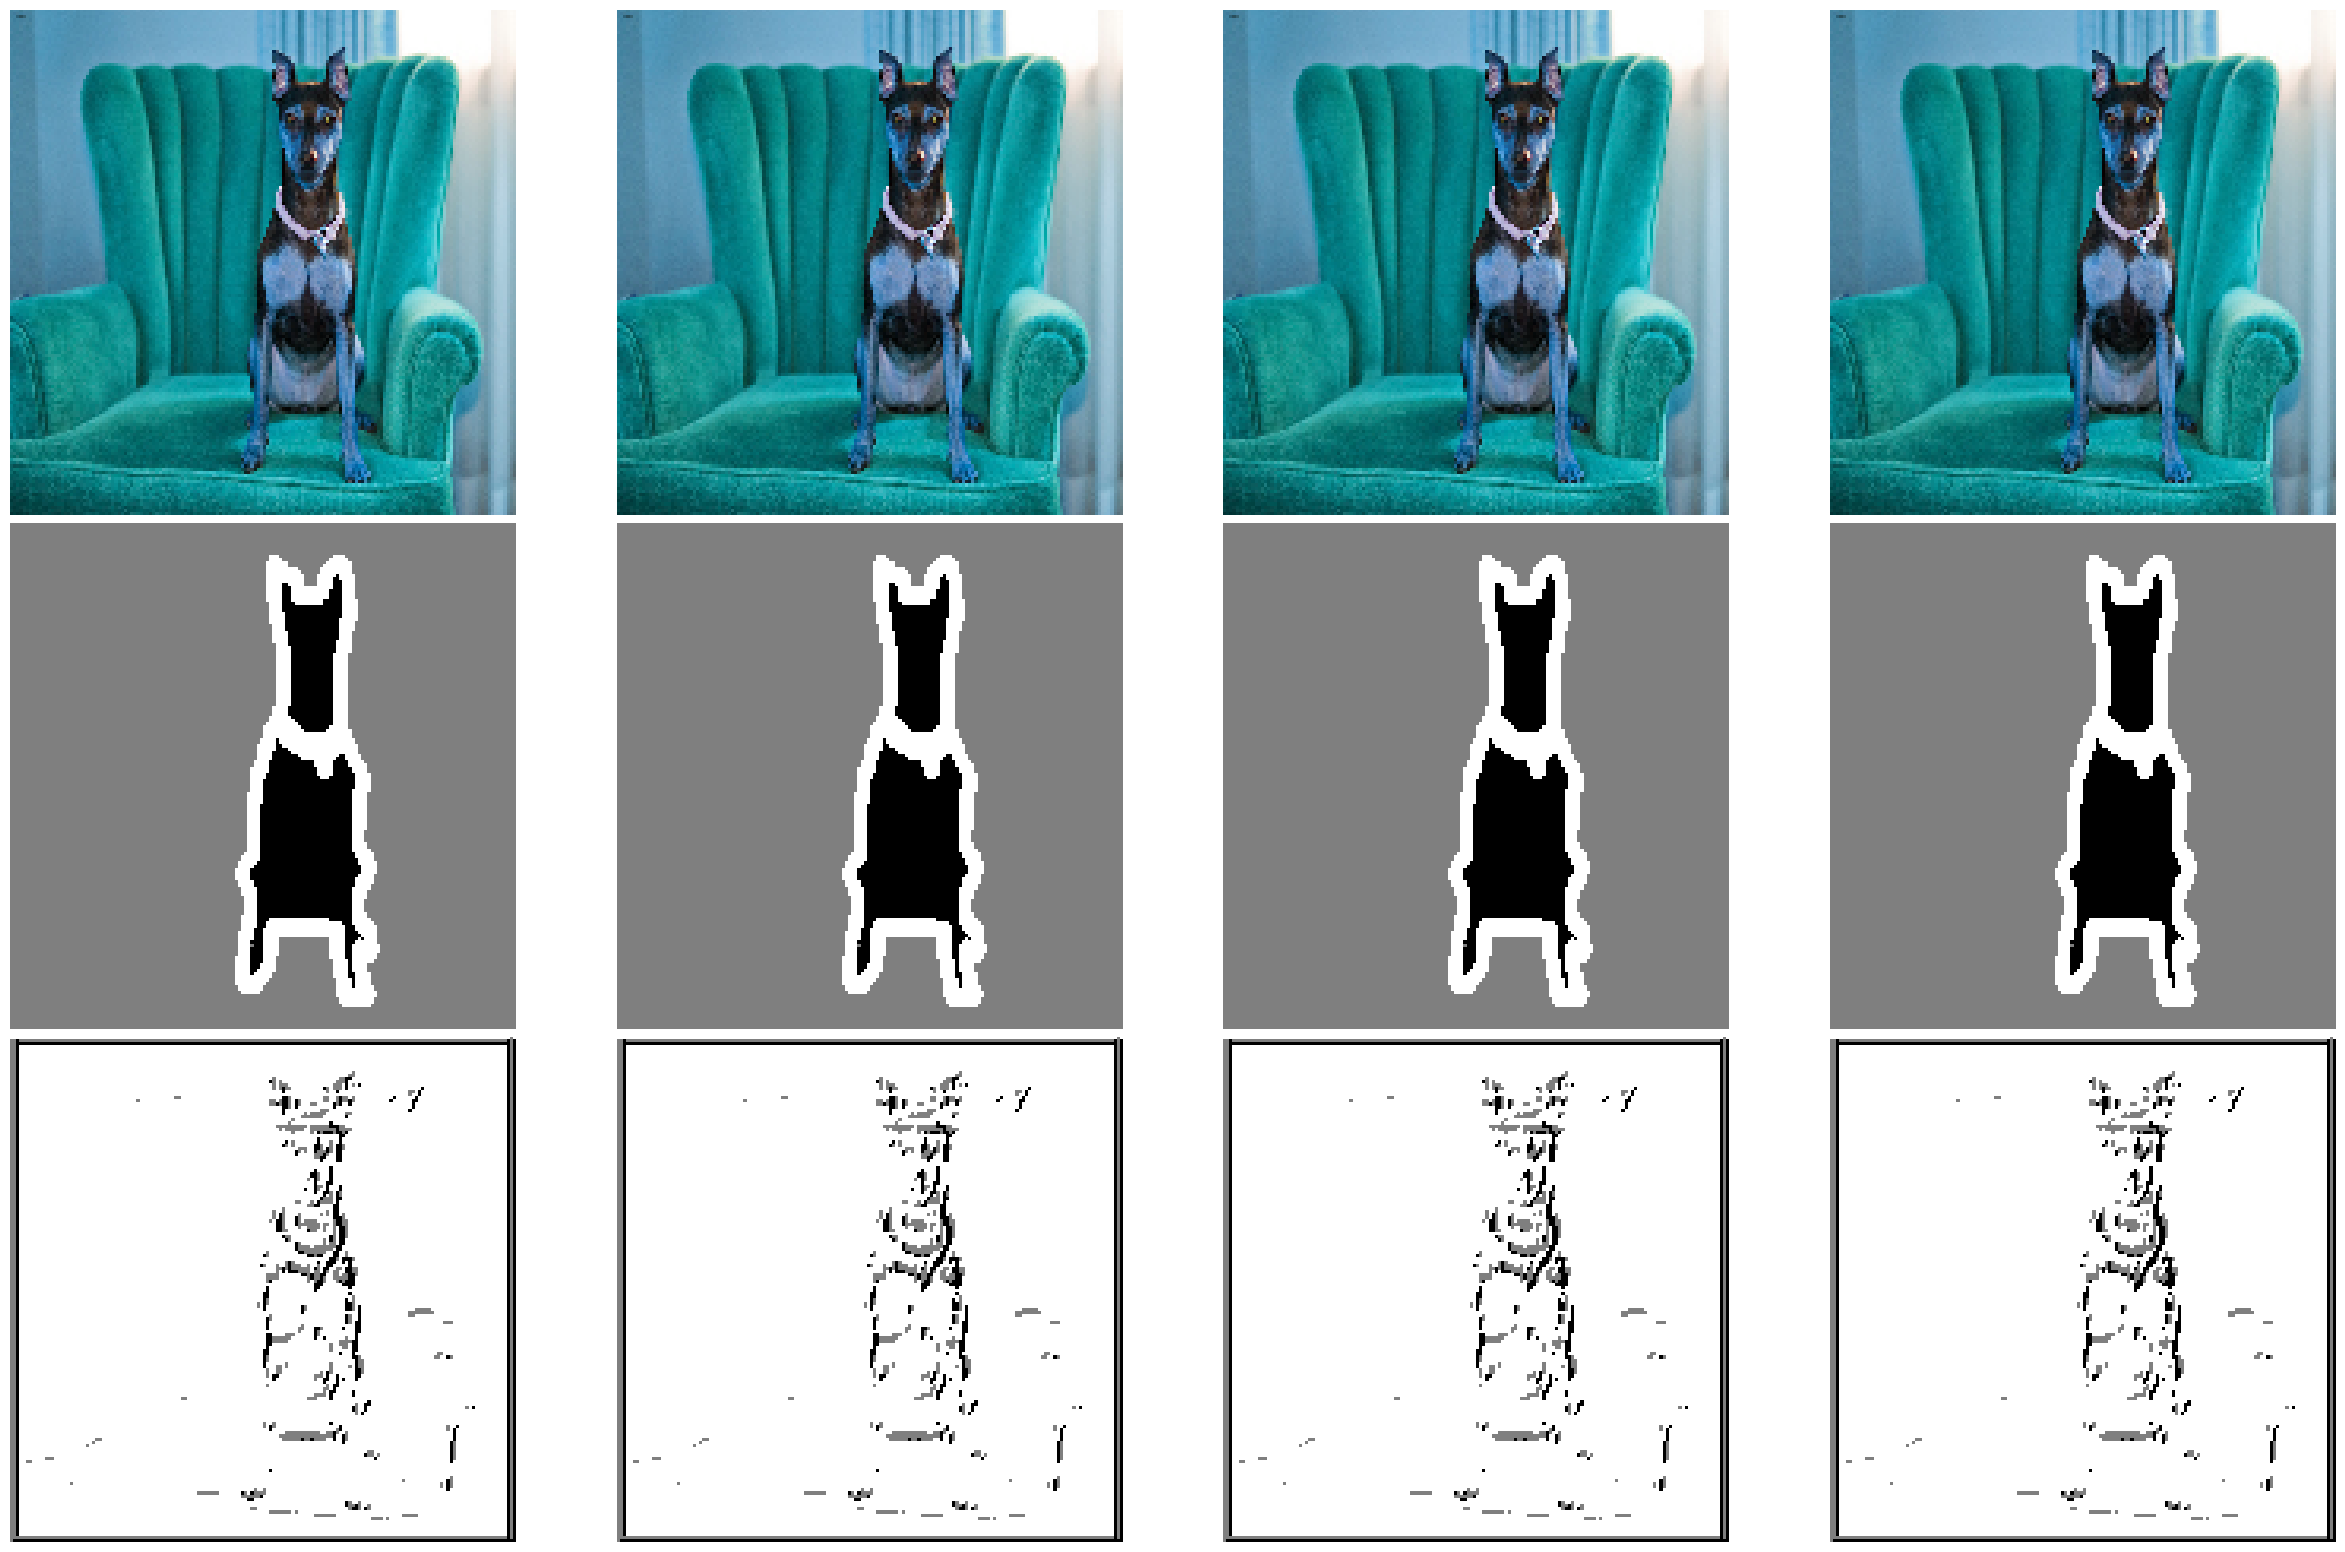

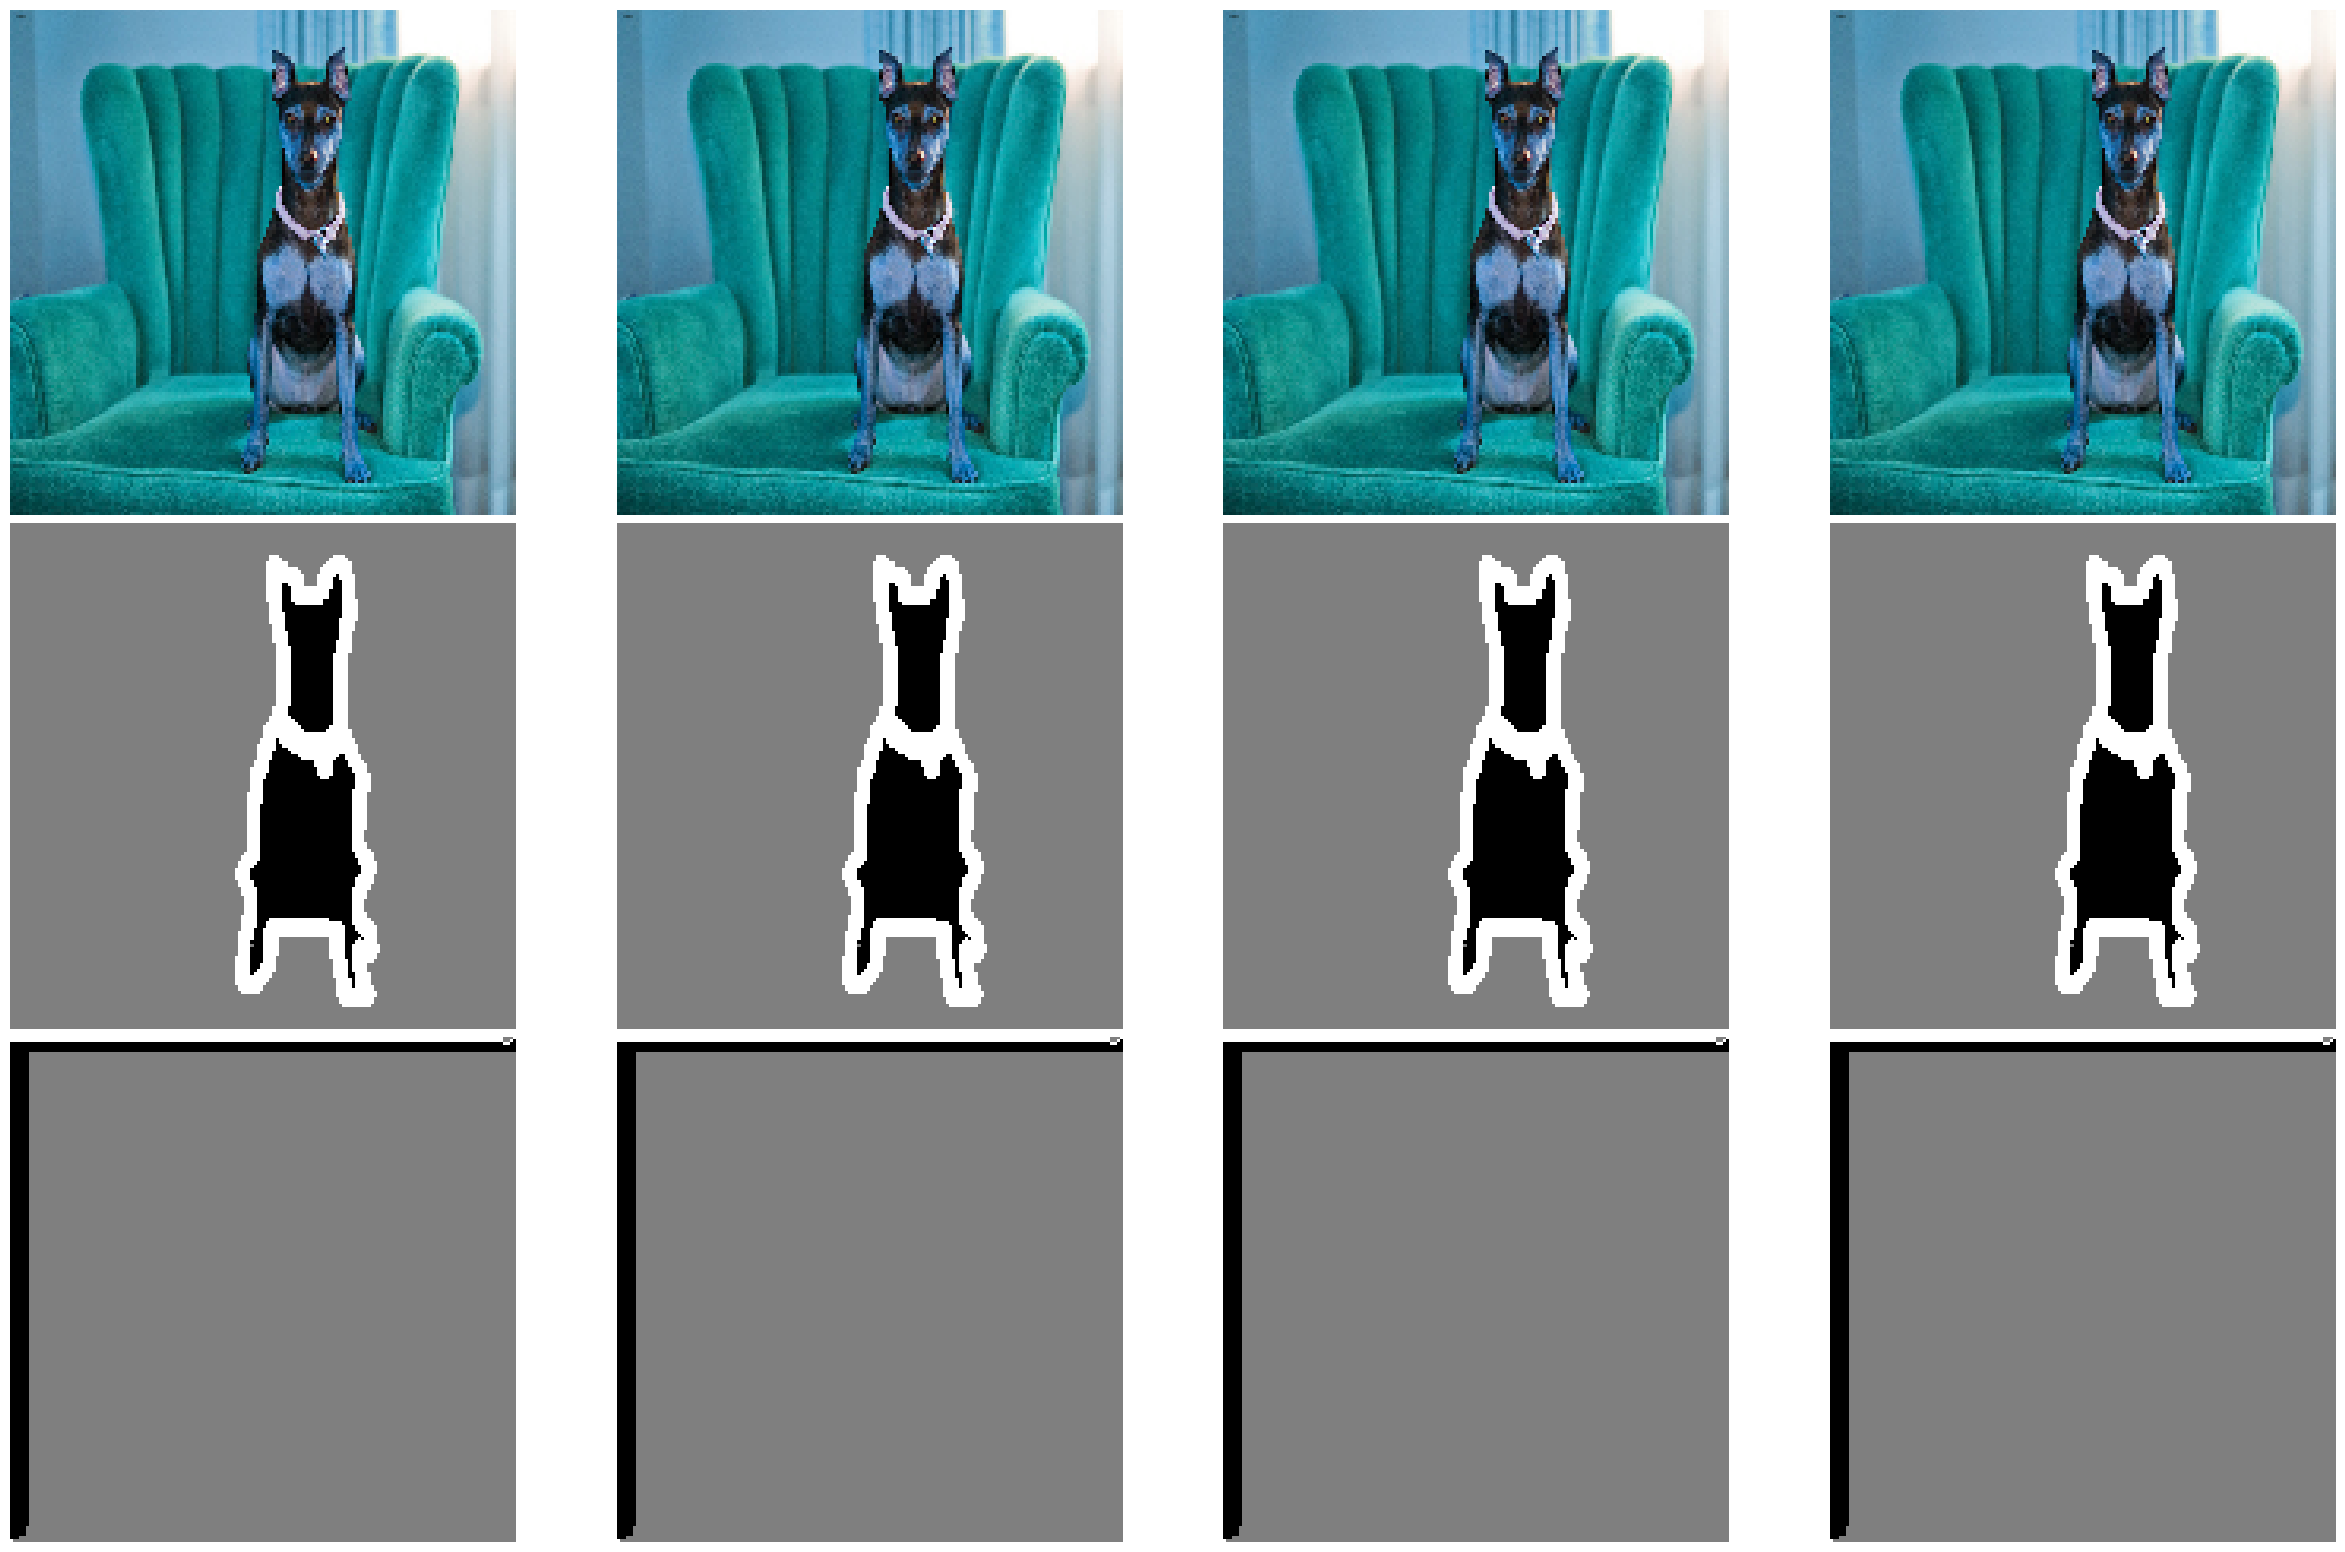

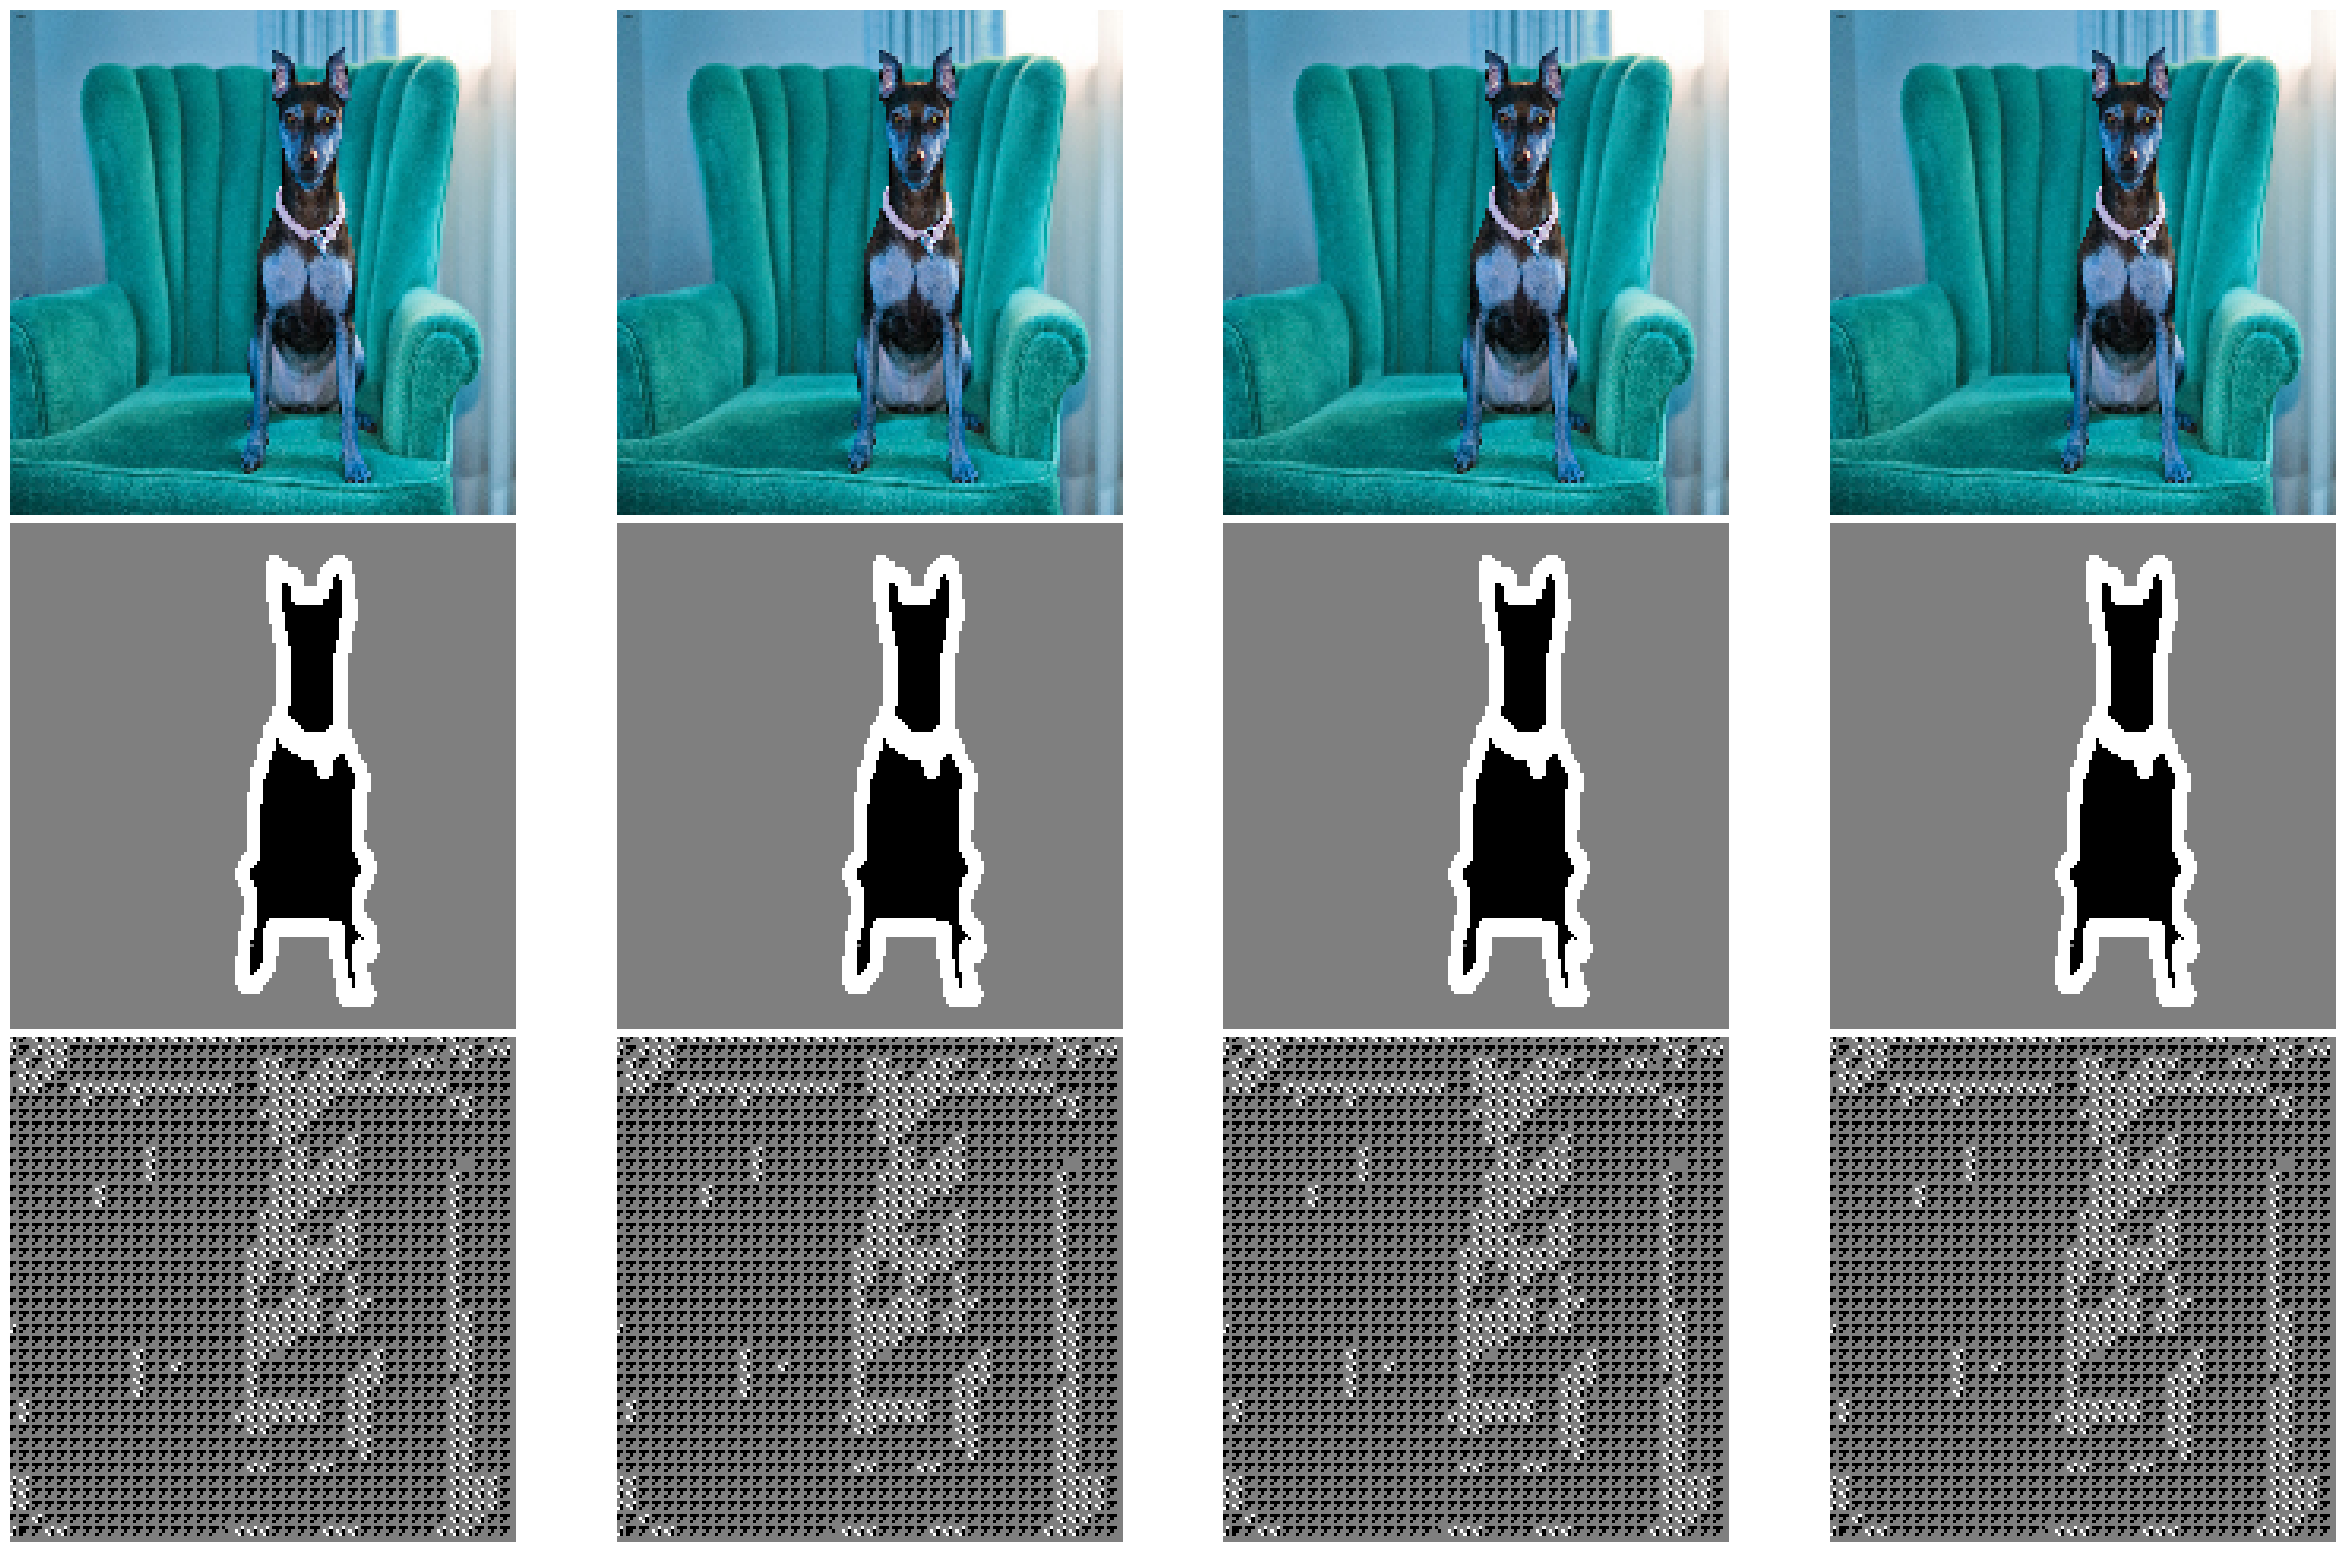

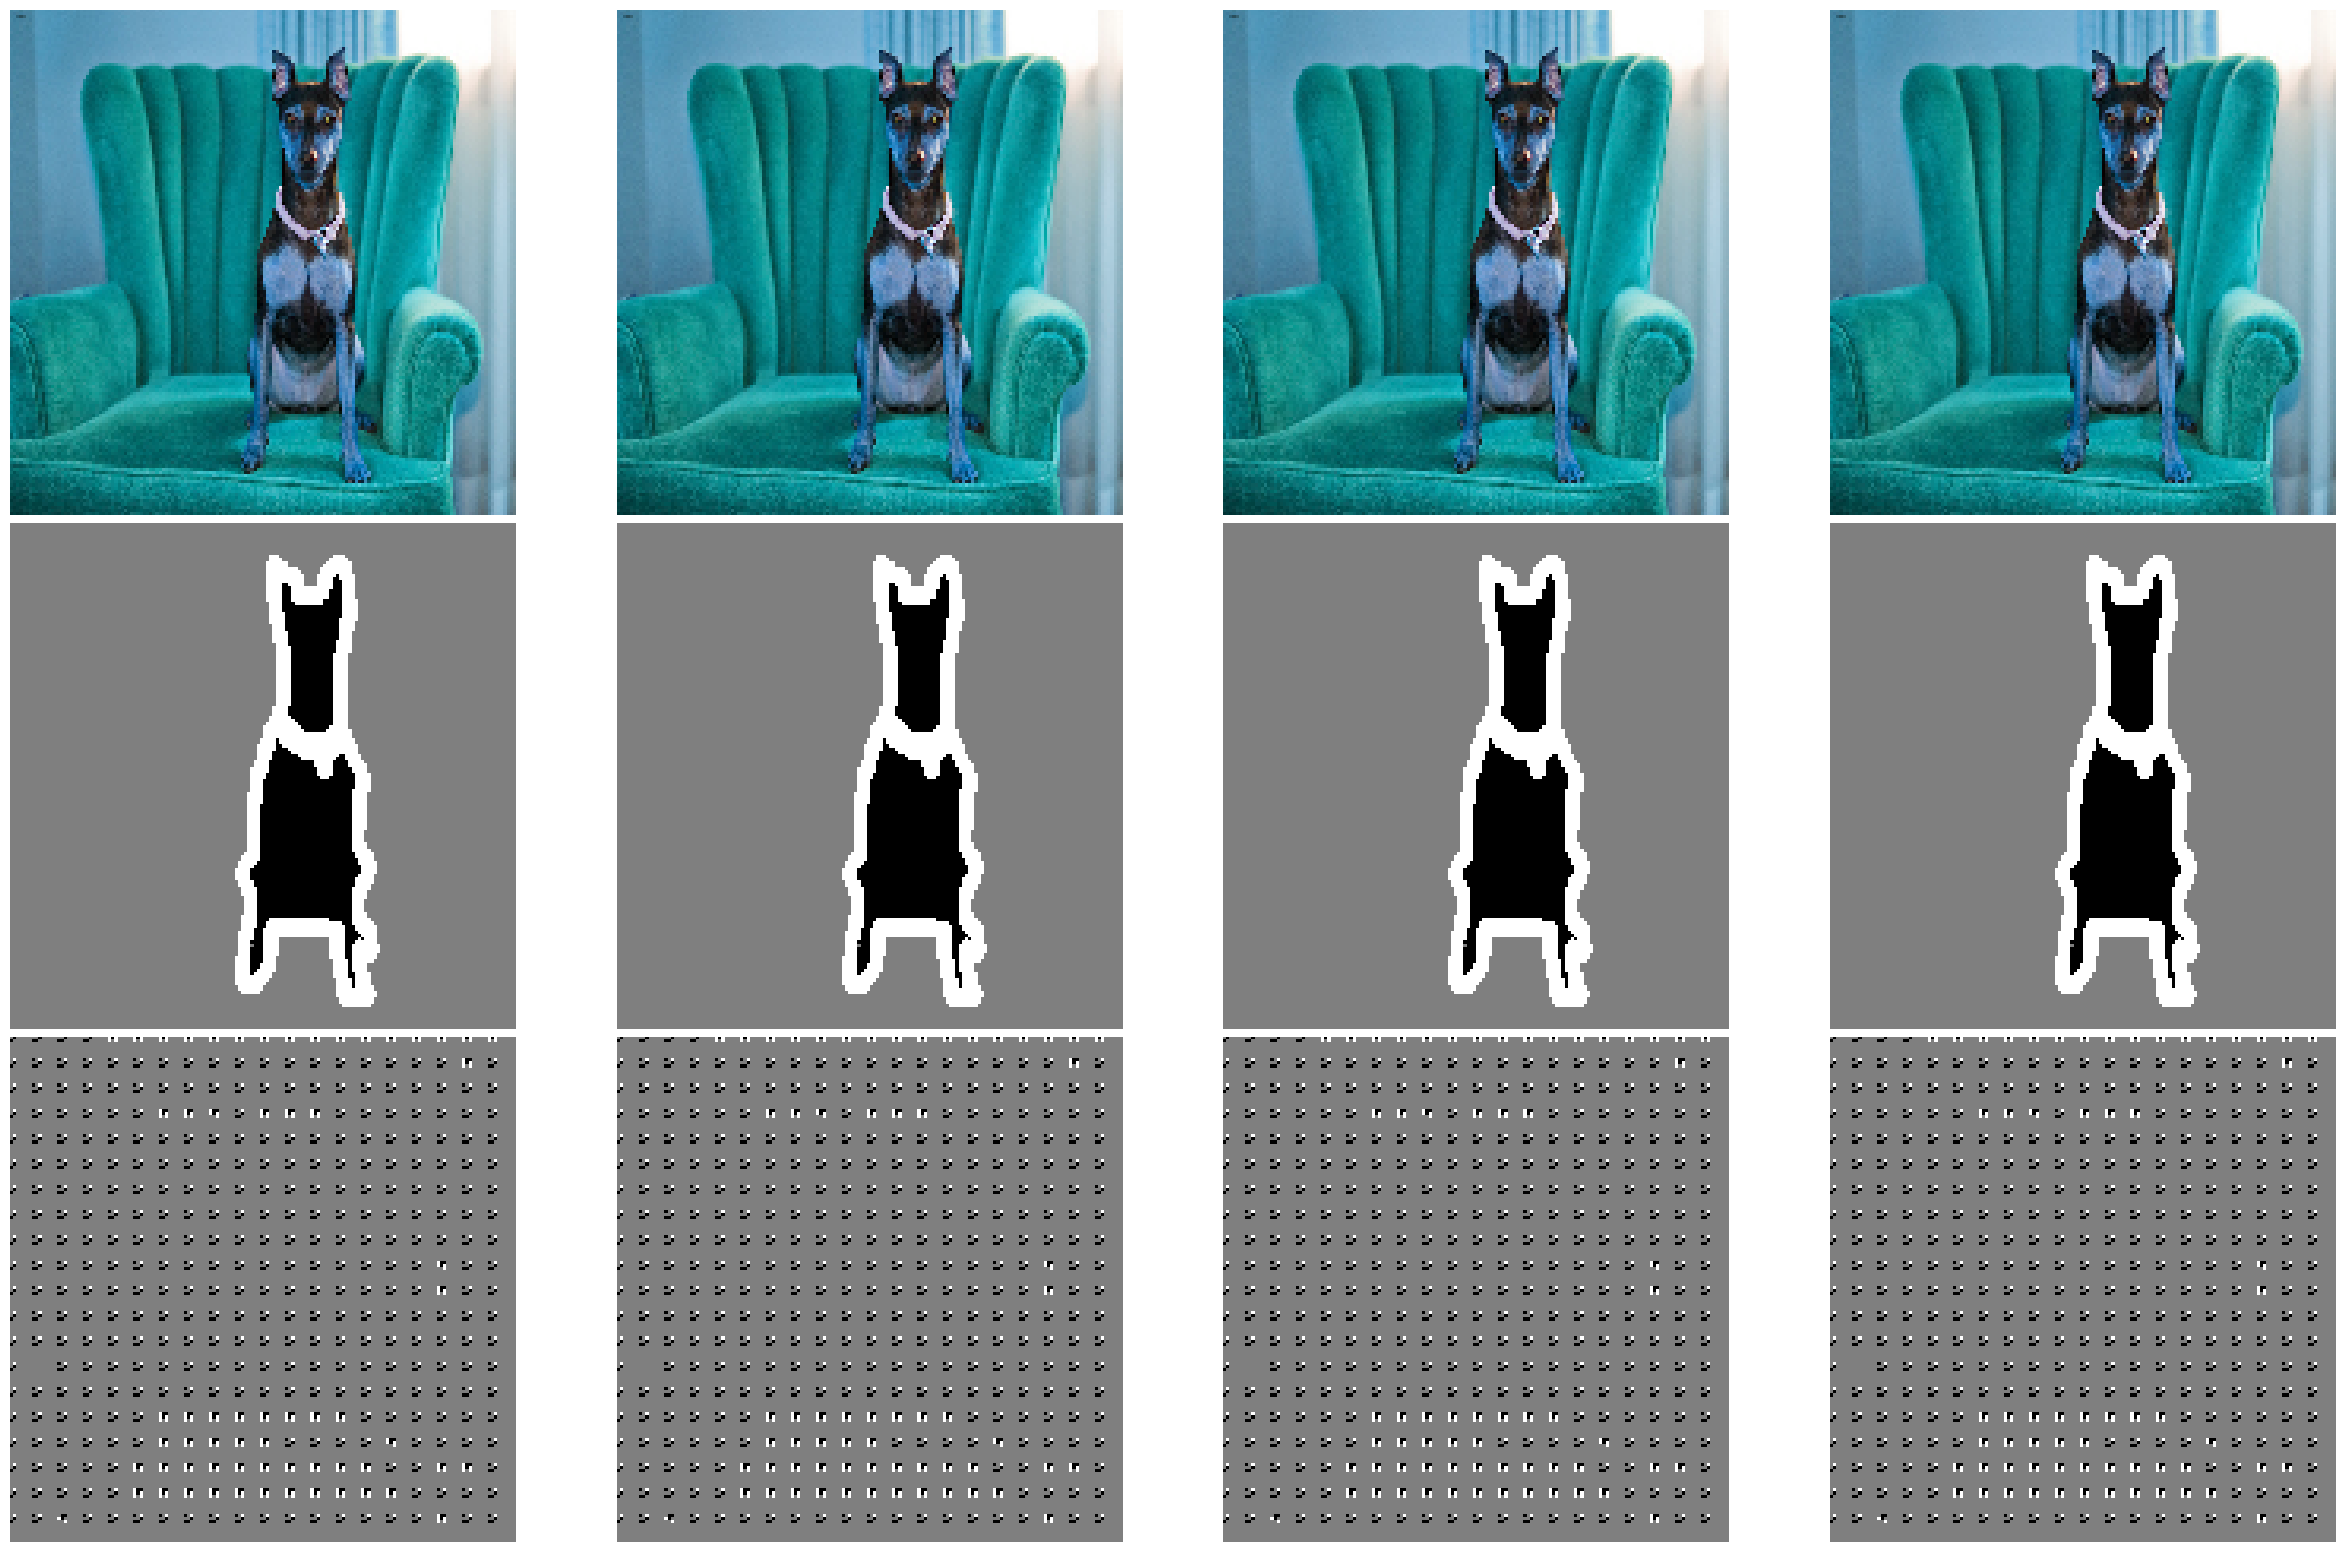

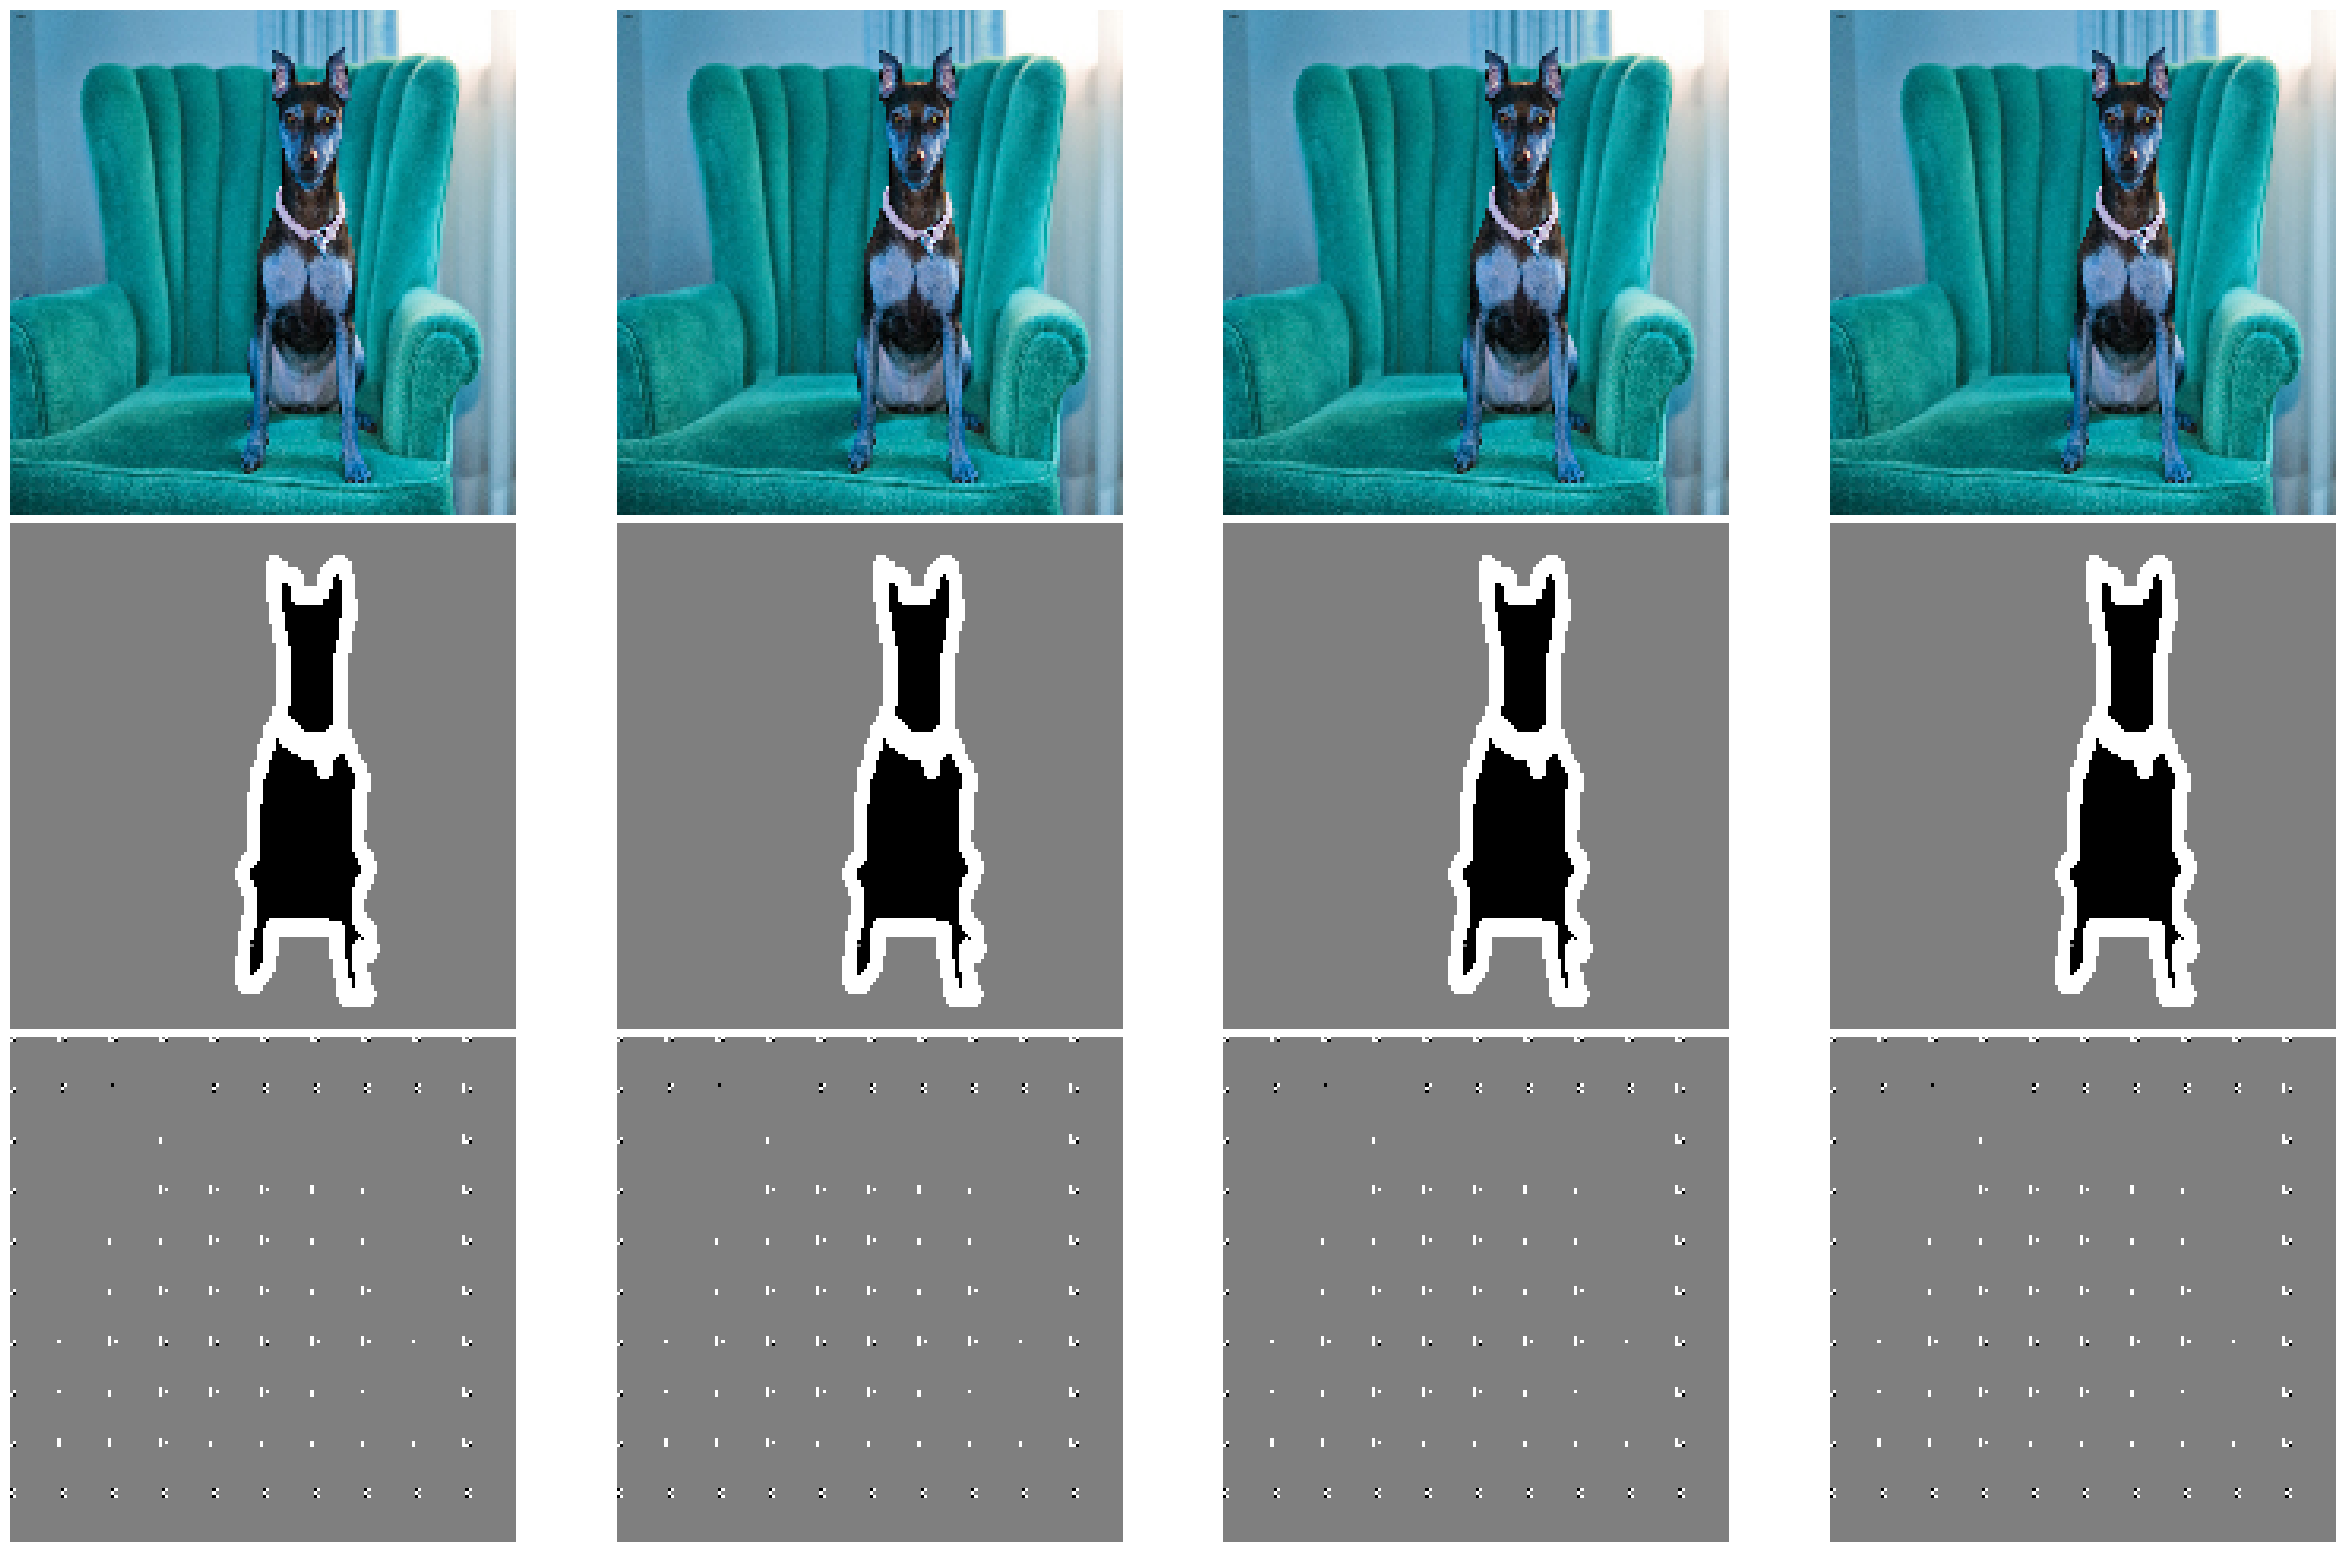

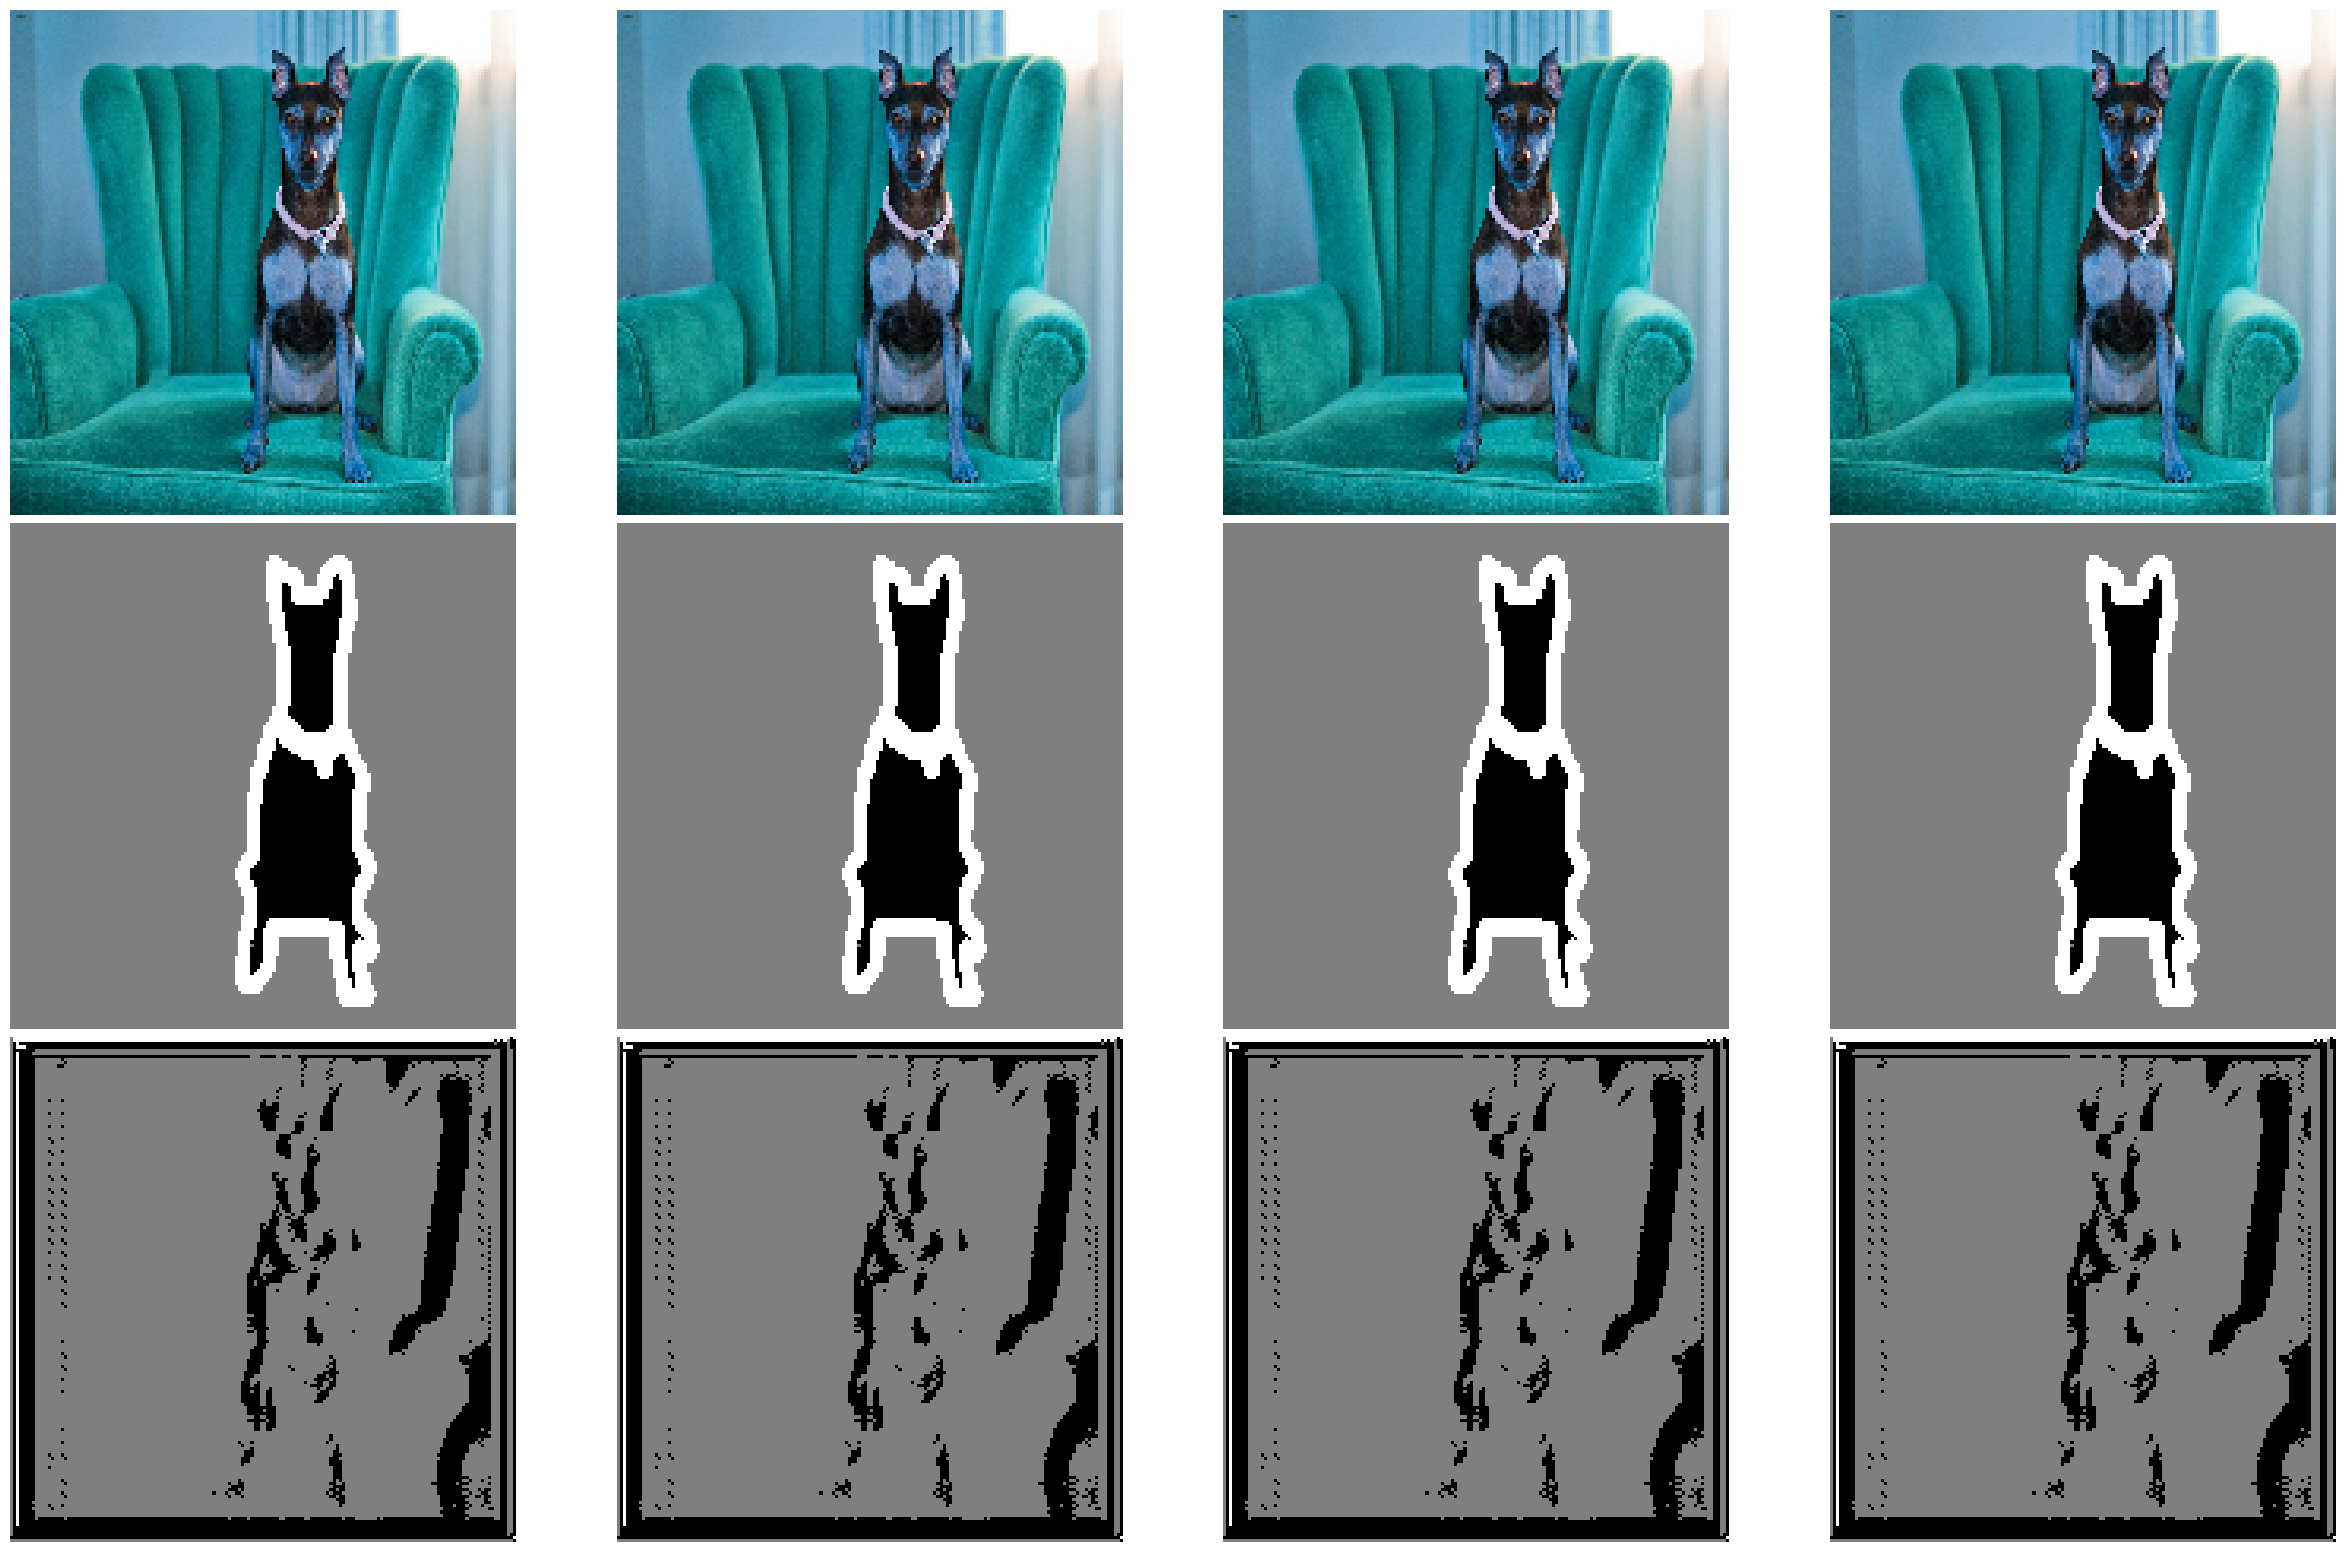

In [13]:

if INTERACTIVE_SESSION:
    for out_no in range(6):
        print(f"output {out_no}")
        pets.display_sample_image(y_preds[out_no], 'test')
    

In [14]:
# model.evaluate(x=test_dataset)


In [15]:
# Using scikit-learn
for out_no in range(6):
    print(f"{'='*33}\n\toutput {out_no}\n{'-'*33}")
    scores = m_obj.evaluate_sklearn(test_dataset, y_preds[out_no], report=True, average='weighted')
    print(scores)

	output 0
---------------------------------
evaluation elapsed time:___ 0.00___minutes
                 0         1        2  accuracy  macro avg  weighted avg
precision     0.15      0.64     0.07      0.11       0.29          0.55
recall        0.08      0.04     0.78      0.11       0.30          0.11
f1-score      0.11      0.08     0.13      0.11       0.11          0.08
support    2216.00  21277.00  2107.00      0.11   25600.00      25600.00
{'Avg-precision': 0.68, 'f1-score(ODS)': 0.08}
	output 1
---------------------------------
evaluation elapsed time:___ 0.00___minutes
                0         1       2  accuracy  macro avg  weighted avg
precision     0.0      0.82     0.0      0.76       0.27          0.68
recall        0.0      0.92     0.0      0.76       0.31          0.76
f1-score      0.0      0.87     0.0      0.76       0.29          0.72
support    2216.0  21277.00  2107.0      0.76   25600.00      25600.00
{'Avg-precision': 0.7, 'f1-score(ODS)': 0.87}
	output 2
---

evaluation elapsed time:___ 0.00___minutes
                 0         1        2  accuracy  macro avg  weighted avg
precision     0.07      0.83     0.25      0.61       0.39          0.72
recall        0.23      0.70     0.11      0.61       0.35          0.61
f1-score      0.11      0.76     0.15      0.61       0.34          0.65
support    2216.00  21277.00  2107.00      0.61   25600.00      25600.00
{'Avg-precision': 0.73, 'f1-score(ODS)': 0.76}
	output 3
---------------------------------
evaluation elapsed time:___ 0.00___minutes
                 0         1        2  accuracy  macro avg  weighted avg
precision     0.09      0.83     0.11      0.77       0.34          0.71
recall        0.06      0.92     0.03      0.77       0.34          0.77
f1-score      0.07      0.87     0.05      0.77       0.33          0.74
support    2216.00  21277.00  2107.00      0.77   25600.00      25600.00
{'Avg-precision': 0.71, 'f1-score(ODS)': 0.87}
	output 4
---------------------------------
ev

In [16]:
!mv oxford_pets_hed.nbconvert.ipynb conf.save_path

/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)
mv: cannot stat 'oxford_pets_hed.nbconvert.ipynb': No such file or directory
